# Model Validation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error,mean_absolute_error
from scipy.optimize import newton
import time
import queue as Q

In [2]:
# load the data 
COLS_TO_USE = [4,5,6,9,10,12,13,14,15,16]
HEADER_NAMES = ['size','weight','received_time','fee','confirmed_block_height','confirm_time','waiting_time','fee_rate','enter_block_height','no_block_confirm']

d1 = pd.read_csv('data/TimetxinBlock621500.csv', usecols=COLS_TO_USE, names=HEADER_NAMES)
d2 = pd.read_csv('data/TimetxinBlock622000.csv', usecols=COLS_TO_USE, names=HEADER_NAMES)
d3 = pd.read_csv('data/TimetxinBlock622500.csv', usecols=COLS_TO_USE, names=HEADER_NAMES)

dataFrame = pd.concat([d1, d2, d3])

dataFrame = dataFrame[dataFrame['waiting_time'] >= 0] 


test1 = pd.read_csv("data/621237_621281_Test_Selected.csv")
test1.columns = ['index','inputs','outputs','trans_version','trans_size','trans_weight','received_time','relay_node','locktime','trans_fee','confirmed_block_height','index_block_height','confirm_time','waiting_time','fee_rate','enter_block_height','no_block_confirm','valid_time','valid_block_height','valid_waiting','last_block_interval']
# test2 does not have a 'last block interval' column
test2 = pd.read_csv("data/622237_622281_Test_Selected.csv")
test2.columns = ['index','inputs','outputs','trans_version','trans_size','trans_weight','received_time','relay_node','locktime','trans_fee','confirmed_block_height','index_block_height','confirm_time','waiting_time','fee_rate','enter_block_height','no_block_confirm','valid_time','valid_block_height','valid_waiting']
test_set = pd.concat ([test1,test2], ignore_index=True)
test_set = test_set.dropna()

## Mathematical Model

In [3]:
# Build sample model data/output

# load data (again)
P_GROUP_BOUNDS = [1,3,10]


print("Transaction Count: ", len(dataFrame))
dataFrame.head(10)

# block size
block_groups = dataFrame.groupby(['confirmed_block_height'])['confirmed_block_height'].count()
mean_block_size = float(round(block_groups.mean()))
print("Mean Block Size: ", mean_block_size)

# feerate priority range
def calculate_feerate_for_priority_groups(data, upper_boundary):
    feerate_range = []
    transaction_counts = 0
    feerate_range.append(data['fee_rate'].max())
    for i in range(len(P_GROUP_BOUNDS)):
        transaction_counts = len(data[data['no_block_confirm'] <= upper_boundary[i]])
        #boundary = data['fee_rate'].nlargest(transaction_counts).iloc[-1]
        boundary = data['fee_rate'].tail(transaction_counts).iloc[0]
        feerate_range.append(boundary)
    return feerate_range


p_groups_feerate_range = calculate_feerate_for_priority_groups(dataFrame.sort_values('fee_rate'), P_GROUP_BOUNDS)
p_groups_feerate_range.append(0.0)
print("one block waited ration: ", p_groups_feerate_range, "\n")

# arrival rate priority - Lambda
p_groups_lambda = []
transaction_count = len(dataFrame)
received_time_max = dataFrame['received_time'].max()
received_time_min = dataFrame['received_time'].min()

p_group_wait_times = [] # for analysis later

for current, next in zip(p_groups_feerate_range,p_groups_feerate_range[1:]):
    p_df = dataFrame[(dataFrame['fee_rate'] <= current) & (dataFrame['fee_rate'] > next)]
    p_transaction_count = len(p_df)
    #p_lambda = float(p_transaction_count) / (float(p_df['received_time'].max()) - float(p_df['received_time'].min()))
    p_lambda = float(p_transaction_count) / (received_time_max - received_time_min)
    p_groups_lambda.append(p_lambda)
    p_group_wait_times.append(p_df['waiting_time'].mean())
    
    print("Priority Group " + str(p_groups_feerate_range.index(current)+1))
    print("Transaction Count: ", p_transaction_count)
    print("Feerate Min: ", float(p_df['fee_rate'].min()))
    print("Feerate Max: ", float(p_df['fee_rate'].max()))
    print("Mean Wait Time: ", float(p_df['waiting_time'].mean()))
    print("Lambda: " + str(p_lambda) + "\n")
    
print("Sum Of All Lambda: ", sum(p_groups_lambda))

# service rate - Mu
service_time = 600
mu = 1/service_time # Our Original Mu = 0.0016666666666666668
#mu = (1/service_time)*mean_block_size # Our New Mu = 3.776666666666667
print("Mu: ", mu)

# Z-Validation (Newton's Method)

my_p_group_z = []
sciPy_p_group_z = []
lambda_sum = 0.0

def NewtonMethod(lam, m_u, block_size, x0, epsilon):
    fx = lambda x: lam*(1 - x) - m_u*x*(1 - x**block_size)
    dfx = lambda x: m_u*(block_size*x**block_size + x**block_size - 1) - lam
    while True:
        x1 = x0 - fx(x0) / dfx(x0)
        t = abs(x1 - x0)
        if t < epsilon:
            break
        x0 = x1
    return x0

def SciPyNewton(lam, m_u, block_size, x0, epsilon, max_iteration):
    fx = lambda x: lam*(1 - x) - m_u*x*(1 - x**block_size)
    #dfx = lambda x: m_u*(block_size*x**block_size + x**block_size - 1) - lam
    #return newton(fx, x0, fprime=dfx, args=(), tol=epsilon, maxiter=max_iteration, fprime2=None)
    return newton(fx, x0, fprime=None, args=(), tol=epsilon, maxiter=max_iteration, fprime2=None)

for i in range(len(p_groups_lambda)):
    lambda_sum += p_groups_lambda[i]
    my_p_group_z.append(NewtonMethod(lambda_sum, mu, mean_block_size, 0, 1e-10))
    sciPy_p_group_z.append(SciPyNewton(lambda_sum, mu, mean_block_size, 0, 1e-10, 500))

for i in range(len(my_p_group_z)):
    print("Priority Group " + str(i+1))
    print("My Z: \n" + str(my_p_group_z[i]))
    print("SciPy Z: \n" + str(sciPy_p_group_z[i]))
    print("Variance: \n" + '{:.16f}'.format(abs(my_p_group_z[i] - sciPy_p_group_z[i]))+ "\n")
    
prev_transaction_in_queue = 0.0
p_group_response_time = []

for i in range(len(p_groups_lambda)):
    temp = sciPy_p_group_z[i] / (1 - sciPy_p_group_z[i]) # L(y) = z(x) / (1 - z(x))
    transaction_in_queue = temp - prev_transaction_in_queue # L(x) = L(y) - L(y-1)
    prev_transaction_in_queue = temp
    
    #transaction_in_queue = my_p_group_z[i] / (1 - my_p_group_z[i]) - prev_transaction_in_queue # L(x) = (z(x) / (1 - z(x))) - L(x-1)
    #prev_transaction_in_queue = transaction_in_queue

    response_time = transaction_in_queue / p_groups_lambda[i] # W(x) = L(x) / Lambda(x)
    p_group_response_time.append(response_time)

    print("Priority Group " + str(i+1))
    print("Average Transaction In Queue (L): ", transaction_in_queue)
    print("Average Response Time In Queue (W): " + str(response_time))

Transaction Count:  3389521
Mean Block Size:  2266.0
one block waited ration:  [52380.95238095238, 30.175438596491237, 18.529411764705888, 5.0, 0.0] 

Priority Group 1
Transaction Count:  2035967
Feerate Min:  30.175580221997983
Feerate Max:  52380.95238095238
Mean Wait Time:  2474.0209728350214
Lambda: 1.851985231178986

Priority Group 2
Transaction Count:  565691
Feerate Min:  18.52950075642965
Feerate Max:  30.175438596491237
Mean Wait Time:  6085.267361510082
Lambda: 0.5145718852078014

Priority Group 3
Transaction Count:  385863
Feerate Min:  5.000028548752705
Feerate Max:  18.529411764705888
Mean Wait Time:  9987.642969136714
Lambda: 0.3509941847085032

Priority Group 4
Transaction Count:  402000
Feerate Min:  0.907563025210084
Feerate Max:  5.0
Mean Wait Time:  11979.932554726369
Lambda: 0.36567295193583804

Sum Of All Lambda:  3.083224253031129
Mu:  0.0016666666666666668
Priority Group 1
My Z: 
0.9992742750913941
SciPy Z: 
0.9992742751058932
Variance: 
0.0000000000144991

Prior

## Simulation Model

In [4]:
# # Queueing Model

# reference 
# 
# https://docs.python.org/3/library/queue.html
# 
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html

from scipy import stats
import time
import queue as Q
from collections import deque
from collections import namedtuple as nt

# Data Loading

# load the data 
data1 = pd.read_csv("data/TimetxinBlock621500.csv")
data1.columns = ['index', 'inputs', 'outputs', 'trans_version', 'trans_size', 'trans_weight', 'received_time',
                 'relay_node', 'locktime', 'trans_fee', 'confirmed_block_height', 'index_block_height', 'confirm_time',
                 'waiting_time', 'feerate', 'enter_block_height', 'waiting_block_num', 'valid_time',
                 'valid_block_height', 'valid_waiting', 'last_block_interval']
data2 = pd.read_csv("data/TimetxinBlock622000.csv")
data2.columns = ['index', 'inputs', 'outputs', 'trans_version', 'trans_size', 'trans_weight', 'received_time',
                 'relay_node', 'locktime', 'trans_fee', 'confirmed_block_height', 'index_block_height', 'confirm_time',
                 'waiting_time', 'feerate', 'enter_block_height', 'waiting_block_num', 'valid_time',
                 'valid_block_height', 'valid_waiting', 'last_block_interval']
data3 = pd.read_csv("data/TimetxinBlock622500.csv")
data3.columns = ['index', 'inputs', 'outputs', 'trans_version', 'trans_size', 'trans_weight', 'received_time',
                 'relay_node', 'locktime', 'trans_fee', 'confirmed_block_height', 'index_block_height', 'confirm_time',
                 'waiting_time', 'feerate', 'enter_block_height', 'waiting_block_num', 'valid_time',
                 'valid_block_height', 'valid_waiting', 'last_block_interval']

# combine the data into one dataframe
data = pd.concat([data1, data2, data3], ignore_index=True)
# data1.columns=['index','inputs','outputs','trans_version','trans_size','trans_weight','received_time','relay_node','locktime','trans_fee','confirmed_block_height','index_block_height','confirm_time','waiting_time','feerate','enter_block_height','waiting_block_num','valid_time','valid_block_height','valid_waiting','last_block_interval']
print(data.shape)
data = data.sort_values(by=['received_time'])
data.head(20)

max_block = data['waiting_block_num'].max()
print(max_block)
data['waiting_block_num'].describe()
print(data['received_time'].max())

# input Parameters

# lambda calculation - arrival rate 
total_trans_num = len(data.index)
print("Total number of transactions: ", total_trans_num)

data_sort_by_receive = data.sort_values(by='received_time')
first_arrive_time = float(data['received_time'].min())
last_arrive_time = float(data['received_time'].max())
q_lambda = float(total_trans_num) / (last_arrive_time - first_arrive_time)
mean_interarrival_time = 1 / q_lambda
print("lambda is: ", q_lambda)

# mu - service rate
service_time_mean = 600
mu = 1 / service_time_mean
print("Mu is: ", mu)

# total time (seconds)
simulation_time = last_arrive_time - first_arrive_time
print("Total simulation time is: ", simulation_time)

# mempool capacity
trans_size = 535
mempool_size = 300 * 1000000
capacity = mempool_size / trans_size
print("Mempool capacity is ", capacity, " transactions")

# block size 
block_groups = data.groupby(['confirmed_block_height'])['confirmed_block_height'].count()
b = float(round(block_groups.mean()))
print("Mean Block Size: ", b)

# store feerates in a list to feed in the model later 
feerates = data.feerate.tolist()

# initiate results 
results = []

# ## Priority Groups Setup - feerate range calculation


# This function is to calcutate the feerate boundary of each priority group

WAIT_BLOCK_NUM_UPPER_BOUNDARY = [1, 3, 10]

length = len(WAIT_BLOCK_NUM_UPPER_BOUNDARY)


# this function return a list with the feerate boundaries for each priority group
def calculate_feerate_for_priority_groups(data, upper_boundary):
    feerate_range = []
    transaction_counts = 0
    for i in range(length):
        transaction_counts = len(data[data['waiting_block_num'] <= upper_boundary[i]])
        boundary = data.feerate.nlargest(transaction_counts).iloc[-1]
        feerate_range.append(boundary)
    return feerate_range


feerate_range = calculate_feerate_for_priority_groups(data, WAIT_BLOCK_NUM_UPPER_BOUNDARY)
print("Feerate boundaries: ", feerate_range)

# # M/M/1 Queueing Model
# 
# The data structure deque is selected becaused deque provides an O(1) time complexity for append and pop operations, so that system drlay can be minimised. 


# initiate variables 
transaction = nt('transaction',
                 ['received_time', 'feerate', 'confirm_time', 'entered_block_height', 'confirmed_block_height'])

q1 = deque()
q2 = deque()
q3 = deque()
q4 = deque()

t = round(time.time())
next_arrival = t
next_confirm = next_arrival + round(np.random.exponential(service_time_mean))
block_height = 620943

# place holder for checking mempool size - not needed for given dataset
# allocate transaction to different priority groups and populating the arrival time  

i = 0
while next_confirm <= t + simulation_time:
    while next_arrival < next_confirm and i < len(feerates):  # transactions come in before the next batch
        feerate = feerates[i]
        if feerate >= feerate_range[0]:
            q1.append(transaction(next_arrival, feerate, 0, block_height, 0))
        if (feerate >= feerate_range[1]) & (feerate < feerate_range[0]):
            q2.append(transaction(next_arrival, feerate, 0, block_height, 0))
        if (feerate >= feerate_range[2]) & (feerate < feerate_range[1]):
            q3.append(transaction(next_arrival, feerate, 0, block_height, 0))
        if feerate < feerate_range[2]:
            q4.append(transaction(next_arrival, feerate, 0, block_height, 0))
        next_arrival += round(np.random.exponential(1 / q_lambda))
        i += 1

    # batch processing with size b
    j = 0
    block_height = block_height + 1
    while q1 and j <= b:
        # - using popleft() to delete element from left end 
        q1[0] = q1[0]._replace(confirm_time=next_confirm)
        q1[0] = q1[0]._replace(confirmed_block_height=block_height)
        confirmed = q1.popleft()
        results.append(confirmed)
        j += 1
    while q2 and j <= b:
        q2[0] = q2[0]._replace(confirm_time=next_confirm)
        q2[0] = q2[0]._replace(confirmed_block_height=block_height)
        confirmed = q2.popleft()
        results.append(confirmed)
        j += 1
    while q3 and j <= b:
        q3[0] = q3[0]._replace(confirm_time=next_confirm)
        q3[0] = q3[0]._replace(confirmed_block_height=block_height)
        confirmed = q3.popleft()
        results.append(confirmed)
        j += 1
    while q4 and j <= b:
        q4[0] = q4[0]._replace(confirm_time=next_confirm)
        q4[0] = q4[0]._replace(confirmed_block_height=block_height)
        confirmed = q4.popleft()
        results.append(confirmed)
        j += 1

    # calculate next confirmation time 
    next_confirm += round(np.random.exponential(service_time_mean))

results_df = pd.DataFrame(results, columns=transaction._fields)
results_df = results_df.apply(pd.to_numeric)
results_df['waiting_time'] = results_df['confirm_time'] - results_df['received_time']
results_df['waited_block_num'] = results_df['confirmed_block_height'] - results_df['entered_block_height']
print(results_df.head(50))
# calculate Average wait time

def calculate_mean_waiting_time(results_df, feerate_range):
    waiting_times = []
    for i in range(len(feerate_range)):
        if i == 0:
            df = results_df[results_df['feerate'] > feerate_range[i]]
            waiting_time_mean = df['waiting_time'].mean()
            waiting_times.append(waiting_time_mean)
        if i < len(feerate_range) - 1:
            df = results_df[results_df['feerate'].between(feerate_range[i + 1], feerate_range[i], inclusive="right")]
            waiting_time_mean = df['waiting_time'].mean()
            waiting_times.append(waiting_time_mean)
        if i == len(feerate_range) - 1:
            df = results_df[results_df['feerate'] <= feerate_range[i]]
            waiting_time_mean = df['waiting_time'].mean()
            waiting_times.append(waiting_time_mean)
    return waiting_times

sim_wait_times = calculate_mean_waiting_time(results_df, feerate_range)
#waiting_times_actual = calculate_mean_waiting_time(data, feerate_range)
#spc = iterative_mean_waiting_time(results_df,feerate_range,10)
#print(spc)
print(sim_wait_times)
#print("mean waiting times for each priority group (from high to low) are: ", sim_wait_times)
#print("mean waiting times for each priority group (from high to low) in raw data are: ", waiting_times_actual)

(3389593, 21)
316
1584856166
Total number of transactions:  3389593
lambda is:  3.083289746694162
Mu is:  0.0016666666666666668
Total simulation time is:  1099343.0
Mempool capacity is  560747.6635514018  transactions
Mean Block Size:  2266.0
Feerate boundaries:  [30.17714002968827, 18.529411764705888, 5.0]
    received_time   feerate  confirm_time  entered_block_height  \
0      1653783759  6.345106    1653784137                620943   
1      1653783763  7.607251    1653784137                620943   
2      1653783764  5.017784    1653784137                620943   
3      1653783768  5.031142    1653784137                620943   
4      1653783768  6.465054    1653784137                620943   
5      1653783770  7.274534    1653784137                620943   
6      1653783770  6.223325    1653784137                620943   
7      1653783770  6.310757    1653784137                620943   
8      1653783782  8.039024    1653784137                620943   
9      1653783782  8.

# Model Output/Historical Data Comparison

In [5]:
# Purpose: provide an overview of the transaction's accuracy.
# Average transaction times overall

pd.set_option('display.float_format', lambda x: '%.5f' % x)
print(data["waiting_time"].describe())
# potentially strip very high values?
# Average transaction time distribution(?)
# data["waiting_time"].plot.hist()


count   3389593.00000
mean       5059.36709
std       15020.12713
min         -10.00000
25%         291.00000
50%         764.00000
75%        2262.00000
max      252015.00000
Name: waiting_time, dtype: float64


## Model Comparison

This section compares the mean wait times of each priority category of the historical data, to the output of the model.

There are four priority categories. These are configurable, and the exact details of these can be seen in the Model Inputs section.

## RMSE Values

In [6]:
# (...)

def calculate_feerate_for_priority_groups(data, upper_boundary):
    feerate_range = []
    transaction_counts = 0
    feerate_range.append(data['fee_rate'].max())
    for i in range(len(P_GROUP_BOUNDS)):
        transaction_counts = len(data[data['no_block_confirm'] <= upper_boundary[i]])
        boundary = data['fee_rate'].tail(transaction_counts).iloc[0]
        feerate_range.append(boundary)
    return feerate_range

test_wait_times = []

def calculate_mean_waiting_time(results_df, feerate_range):
    waiting_times = []
    for i in range(len(feerate_range)):
        if i == 0:
            df = results_df[results_df['fee_rate'] > feerate_range[i]]
            waiting_time_mean = df['waiting_time'].mean()
            waiting_times.append(waiting_time_mean)
        if i < len(feerate_range) - 1:
            df = results_df[results_df['fee_rate'].between(feerate_range[i + 1], feerate_range[i], inclusive="right")]
            waiting_time_mean = df['waiting_time'].mean()
            waiting_times.append(waiting_time_mean)
        if i == len(feerate_range) - 1:
            df = results_df[results_df['fee_rate'] <= feerate_range[i]]
            waiting_time_mean = df['waiting_time'].mean()
            waiting_times.append(waiting_time_mean)
    return waiting_times

test_p_groups_fr_range = calculate_feerate_for_priority_groups(test_set.sort_values('fee_rate'), P_GROUP_BOUNDS)
test_wait_times = calculate_mean_waiting_time(test_set,test_p_groups_fr_range)[1:] #shh

test1 = test1.dropna()
test1_p_groups_fr_range = calculate_feerate_for_priority_groups(test1.sort_values('fee_rate'), P_GROUP_BOUNDS)
test1_wait_times = calculate_mean_waiting_time(test1,test1_p_groups_fr_range)[1:] #shh

test2 = test2.dropna()
test2_p_groups_fr_range = calculate_feerate_for_priority_groups(test2.sort_values('fee_rate'), P_GROUP_BOUNDS)
test2_wait_times = calculate_mean_waiting_time(test2,test2_p_groups_fr_range)[1:] #shh

print(test_wait_times)

print("Root Mean Squared Error: ")
rmse_math = mean_squared_error(p_group_wait_times, p_group_response_time, squared = False)
rmse_sim = mean_squared_error(p_group_wait_times, sim_wait_times, squared = False)
rmse_test = mean_squared_error(p_group_wait_times, test_wait_times, squared = False)
rmse_math_test = mean_squared_error(test_wait_times, p_group_response_time, squared = False)
rmse_math_test1 = mean_squared_error(test1_wait_times, p_group_response_time, squared = False)
rmse_math_test2 = mean_squared_error(test2_wait_times, p_group_response_time, squared = False)
rmse_vals = []
rmse_vals.append(rmse_math)
rmse_vals.append(rmse_sim)
rmse_vals.append(rmse_test)
#rmse_vals.append(rmse_math_test)
rmse_vals.append(rmse_math_test1)
rmse_vals.append(rmse_math_test2)
index = []
index.append("Math")
index.append("Sim")
index.append("Test/Historical")
#index.append("Math/Test") I don't understand
index.append("Math/Test S1")
index.append("Math/Test S2")
rmse_results = pd.DataFrame({'':rmse_vals},index=index)
print(rmse_results)

#print("Math: " + str(rmse_math))
#print("Sim: " + str(rmse_sim))
#print("Test/Historical: " + str(rmse_test))
#print("Math/Test: " + str(rmse_math_test))
#print("Math/Test S1: " + str(rmse_math_test1))
#print("Math/Test S2: "+ str(rmse_math_test2))

print("\nMean Absolute Error: ") # This doesn't seem right.
mae_math = mean_absolute_error(p_group_wait_times, p_group_response_time)
mae_sim = mean_absolute_error(p_group_wait_times, sim_wait_times)
mae_test = mean_absolute_error(p_group_wait_times, test_wait_times)
print("Math: " + str(mae_math))
print("Sim: " + str(mae_sim))
print("Test: " + str(mae_test))

#print("Checking: " + str(mean_squared_error(p_group_wait_times, p_group_wait_times, squared = False)))

[882.5881986160748, 3273.821908928861, 6696.426306212633, 12863.181930423414]
Root Mean Squared Error: 
                            
Math              5245.36685
Sim             243859.61163
Test/Historical   2347.82455
Math/Test S1      4057.11827
Math/Test S2      8437.49172

Mean Absolute Error: 
Math: 4838.66345958767
Sim: 169020.82674636375
Test: 2144.3360663553235


Mean Wait Time Comparison
[[2474.0209728350214, 6085.267361510082, 9987.642969136714, 11979.932554726369]]
[[743.4900615259027, 1638.8303977947135, 2917.0059775136638, 5872.883583023225]]
[[7435.020702449077, 34773.13084809276, 207387.60347222583, 457014.4158208955]]
    Historical  Mathematical   Simulation
P1  2474.02097     743.49006   7435.02070
P2  6085.26736    1638.83040  34773.13085
P3  9987.64297    2917.00598 207387.60347
P4 11979.93255    5872.88358 457014.41582


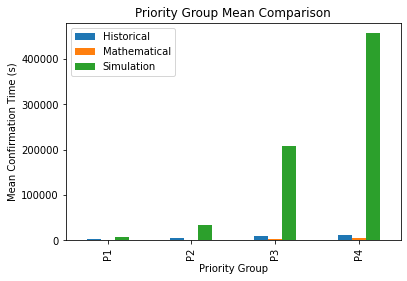

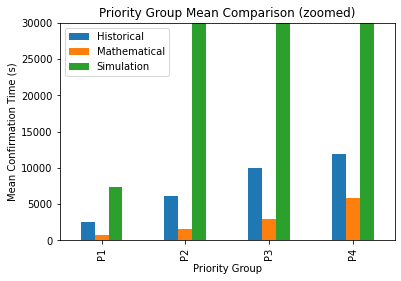

In [7]:
# Purpose: see how accurately the model can capture the behaviour of transactions, based on transaction-priority.
# Print data split into queues (above in model loading section)
import plotly.express as px

print("Mean Wait Time Comparison")
index = []
for i in range(len(p_group_wait_times)):
    index.append('P'+str(i+1))
    
#index.append('Overall')

historical_data = []
historical_data.append(p_group_wait_times)
#historical_data.append(data['waiting_time'].mean())

mathematical_data = []
mathematical_data.append(p_group_response_time)
#mathematical_data.append(sum(p_group_response_time)/len(p_group_response_time))

simulation_data = []
simulation_data.append(sim_wait_times)
#simulation_data.append(results_df['waiting_time'].mean())
    
print(historical_data)
print(mathematical_data)
print(simulation_data)
data_comparison = pd.DataFrame({'Historical':p_group_wait_times,
                                #'Test Set': test_wait_times,
                                'Mathematical':p_group_response_time,
                                'Simulation':sim_wait_times},
                               index=index)
print(data_comparison)
data_comparison.plot.bar()
plt.title("Priority Group Mean Comparison")
plt.xlabel("Priority Group")
plt.ylabel("Mean Confirmation Time (s)")
plt.savefig('plots/plot.png',bbox_inches='tight')
#px.to_html(ax.figure)#.write_html("plots/plot.html")

data_comparison.plot.bar(ylim=(0,30000))
plt.title("Priority Group Mean Comparison (zoomed)")
plt.xlabel("Priority Group")
plt.ylabel("Mean Confirmation Time (s)")
plt.savefig('plots/zoomed_plot.png',bbox_inches='tight')
#ax.figure.write_html("plots/zoomed_plot.html")



In [19]:
import pprint
frequencies = {}

for item in dataFrame['no_block_confirm']:
    if item in frequencies:
        frequencies[item] += 1
    else:
        frequencies[item] = 1

filteredFreq = dict(filter(lambda elem: elem[1] <= 20, frequencies.items()))    
pprint.pprint(filteredFreq)

{252: 12,
 255: 7,
 256: 5,
 257: 6,
 258: 5,
 259: 20,
 260: 7,
 262: 1,
 263: 1,
 265: 4,
 266: 3,
 267: 1,
 269: 1,
 270: 2,
 272: 5,
 273: 3,
 274: 16,
 275: 11,
 277: 6,
 278: 7,
 279: 1,
 280: 9,
 281: 2,
 282: 20,
 285: 1,
 286: 5,
 287: 3,
 288: 1,
 292: 2,
 297: 1,
 298: 2,
 300: 1,
 301: 1,
 302: 2,
 305: 1,
 307: 2,
 312: 2,
 316: 2}
